# Location of Manhattan’s Next Breakfast Spot

IBM Applied Data Science Capstone
Capstone Project

Vineet Raichur
May, 2020

## Import necessary libraries

In [1]:
import urllib.request

#get_ipython().system(u' pip install beautifulsoup4')
#from bs4 import BeautifulSoup

import pandas as pd
import numpy as np # library to handle data in a vectorized manner

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

!conda install -c conda-forge geocoder --yes
import geocoder # import geocoder

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# import k-means from clustering stage
from sklearn.cluster import KMeans

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    ------------------------------------------------------------
                       

 ## Load data with NY city borough and neighborhood list

NY city has a total of 5 boroughs and 329 neighborhoods. We will use a dataset that contains the 5 boroughs and a list of the neighborhoods along with their latitude and longitude coordinates within each borough.
https://geo.nyu.edu/catalog/nyu_2451_34572![image.png](attachment:image.png)

Download the dataset

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


Load and explore the dataset

In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

## Tranform the data into a pandas dataframe

In [4]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Loop through the data and fill the dataframe one row at a time

In [5]:
neighborhoods_data = newyork_data['features']

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [6]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


## Create a new dataframe with Manhattan data

In [7]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Number of neighborhoods in Manhattan

In [8]:
manhattan_data.shape

(40, 4)

## Visualize Manhattan and its reighborhoods

Get the geographical coordinates of Manhattan borough

In [9]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


In [10]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

In [11]:
# save the map as HTML file
map_manhattan.save('map_manhattan.html')

## Get venue data for each neighborhood using Foursquare API

Define Foursquare Credentials and Version

In [12]:
CLIENT_ID = 'JHZEFTFI5EMA5DTB5SWOVUNWGBATRBAB15HG2SE1TBGVI1CY' # your Foursquare ID
CLIENT_SECRET = 'HRHTUXSDB2GFQMM1B40FYQCD3YSD1QNWBNAWQQ2GG4SD4YMY' # your Foursquare Secret
VERSION = '20180604' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JHZEFTFI5EMA5DTB5SWOVUNWGBATRBAB15HG2SE1TBGVI1CY
CLIENT_SECRET:HRHTUXSDB2GFQMM1B40FYQCD3YSD1QNWBNAWQQ2GG4SD4YMY


Set up function to get venue data for one neighborhood

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=200):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Run above function iteratively for all neighborhoods

In [14]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )
print('Assembled Manhattan venues data')

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards
Assembled Manhattan venues data


In [15]:
print(manhattan_venues.shape)
manhattan_venues.head()

(3093, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop


Number of unique categories of venues in location data

In [16]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 330 uniques categories.


## Analyze each neighborhood

In [17]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Group rows by neighborhood and by taking the mean of the frequency of occurrence of each venue category

In [18]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Battery Park City,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.014085,0.028169,0.000,0.014085,0.000000
1,Carnegie Hill,0.000000,0.000000,0.00,0.000000,0.011765,0.000000,0.000000,0.000000,0.011765,...,0.00,0.023529,0.000000,0.000000,0.000000,0.011765,0.035294,0.000,0.000000,0.035294
2,Central Harlem,0.000000,0.000000,0.00,0.068182,0.045455,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000
3,Chelsea,0.000000,0.000000,0.00,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000,0.010000,0.000000
4,Chinatown,0.000000,0.000000,0.00,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.010000
5,Civic Center,0.000000,0.000000,0.00,0.000000,0.053763,0.010753,0.000000,0.000000,0.000000,...,0.00,0.010753,0.000000,0.000000,0.010753,0.010753,0.021505,0.000,0.000000,0.032258
6,Clinton,0.000000,0.000000,0.00,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.020000,0.030000,0.000,0.000000,0.000000
7,East Harlem,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000
8,East Village,0.000000,0.000000,0.00,0.000000,0.010000,0.000000,0.000000,0.010000,0.010000,...,0.00,0.020000,0.000000,0.000000,0.000000,0.030000,0.010000,0.000,0.000000,0.000000
9,Financial District,0.000000,0.000000,0.00,0.000000,0.060000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000,0.000000,0.010000


Number of neighborhoods and venue categories

In [21]:
manhattan_grouped.shape

(40, 331)

## Exploratory data analysis

Summary stats of frequency of occurance of breakfast spot and other venue categories of interest

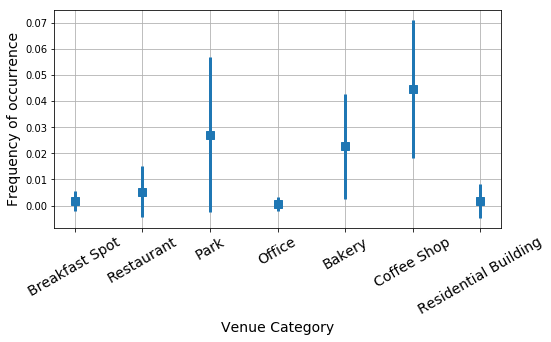

In [28]:
manhattan_bkfst = manhattan_grouped[["Breakfast Spot","Restaurant","Park","Office","Bakery","Coffee Shop","Residential Building (Apartment / Condo)"]]

xtick_label = ["Breakfast Spot","Restaurant","Park","Office","Bakery","Coffee Shop","Residential Building"]
x = np.array([1,2,3,4,5,6,7])
freq_mean = np.array(manhattan_bkfst.mean())
freq_std = np.array(manhattan_bkfst.std())

fig = plt.figure(figsize=(8, 4))
plt.errorbar(x, freq_mean, freq_std, linestyle='None', marker='s', linewidth=3, markersize=8)
plt.xlabel('Venue Category', fontsize=14)
plt.ylabel('Frequency of occurrence', fontsize=14)
plt.xticks([1,2,3,4,5,6,7], xtick_label, fontsize=14, rotation = 30)

plt.grid()
plt.show()

In [29]:
manhattan_bkfst.mean()

Breakfast Spot                              0.001593
Restaurant                                  0.005315
Park                                        0.027085
Office                                      0.000588
Bakery                                      0.022594
Coffee Shop                                 0.044486
Residential Building (Apartment / Condo)    0.001839
dtype: float64

Scatter plot mean of frequency of occurance of breakfast spot vs other venue categories of interest 

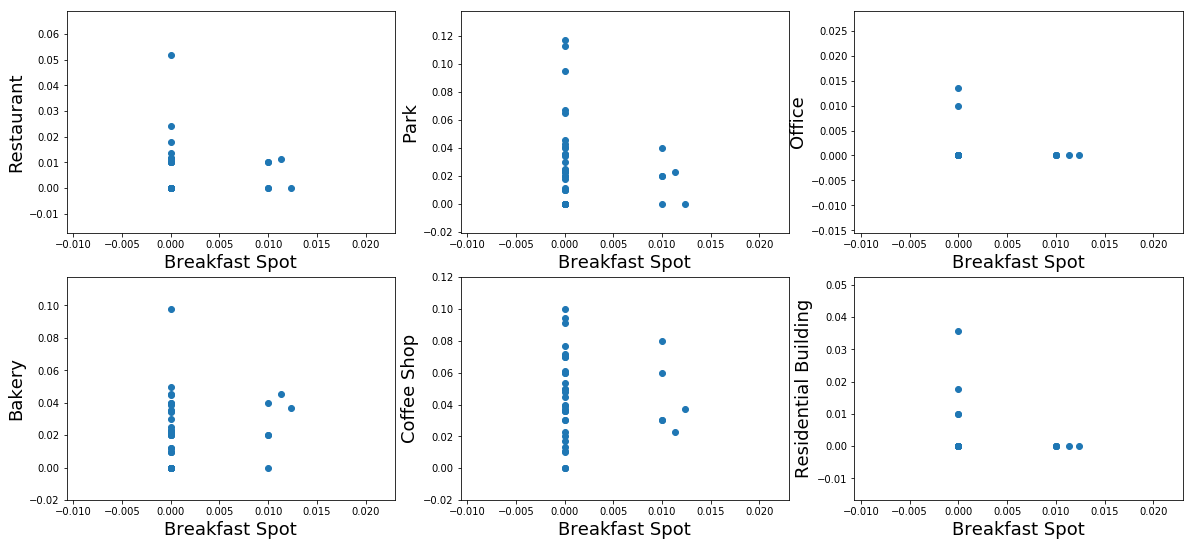

In [30]:
plt_fontsize=18
fig = plt.figure(figsize=(20, 9))
gs = gridspec.GridSpec(nrows=2, ncols=3, figure=fig)
ax0 = fig.add_subplot(gs[0, 0])
ax0.scatter(manhattan_grouped['Breakfast Spot'], manhattan_grouped['Restaurant'])
plt.xlabel('Breakfast Spot', fontsize=plt_fontsize)
plt.ylabel('Restaurant', fontsize=plt_fontsize)
ax1 = fig.add_subplot(gs[0, 1])
ax1.scatter(manhattan_grouped['Breakfast Spot'], manhattan_grouped['Park'])
plt.xlabel('Breakfast Spot', fontsize=plt_fontsize)
plt.ylabel('Park', fontsize=plt_fontsize)
ax2 = fig.add_subplot(gs[0, 2])
ax2.scatter(manhattan_grouped['Breakfast Spot'], manhattan_grouped['Office'])
plt.xlabel('Breakfast Spot', fontsize=plt_fontsize)
plt.ylabel('Office', fontsize=plt_fontsize)
ax2 = fig.add_subplot(gs[1, 0])
ax2.scatter(manhattan_grouped['Breakfast Spot'], manhattan_grouped['Bakery'])
plt.xlabel('Breakfast Spot', fontsize=plt_fontsize)
plt.ylabel('Bakery', fontsize=plt_fontsize)
ax2 = fig.add_subplot(gs[1, 1])
ax2.scatter(manhattan_grouped['Breakfast Spot'], manhattan_grouped['Coffee Shop'])
plt.xlabel('Breakfast Spot', fontsize=plt_fontsize)
plt.ylabel('Coffee Shop', fontsize=plt_fontsize)
ax2 = fig.add_subplot(gs[1, 2])
ax2.scatter(manhattan_grouped['Breakfast Spot'], manhattan_grouped['Residential Building (Apartment / Condo)'])
plt.xlabel('Breakfast Spot', fontsize=plt_fontsize)
plt.ylabel('Residential Building', fontsize=plt_fontsize)

plt.show()

## Cluster neighborhoods

### Create new dataframe with Breakfast Spot data

In [31]:
manhattan_bkfst = manhattan_grouped[["Neighborhood","Breakfast Spot","Restaurant","Park","Office","Bakery","Coffee Shop","Residential Building (Apartment / Condo)"]]

### Find the optimal number of clusters

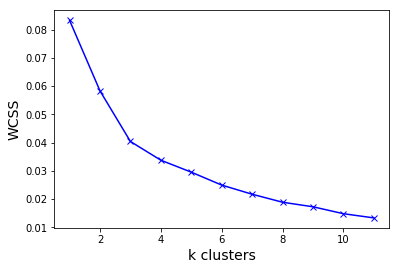

In [32]:
# Within Cluster Sum of Squares (WCSS) method
Sum_of_squared_distances = []
manhattan_grouped_clustering = manhattan_bkfst.drop('Neighborhood', 1)
K = range(1,12)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(manhattan_grouped_clustering)
    Sum_of_squared_distances.append(kmeans.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k clusters', fontsize=14)
plt.ylabel('WCSS', fontsize=14)
plt.show()

Run k-means to cluster the neighborhoods in Manhattan into 4 clusters

In [33]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 3, 1, 5, 2, 1, 3, 5, 1], dtype=int32)

In [34]:
manhattan_merged = manhattan_bkfst.copy()

# add clustering labels
manhattan_merged.insert(0, 'Cluster Labels', kmeans.labels_)

# add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(manhattan_data.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

,Cluster Labels,Neighborhood,Breakfast Spot,Restaurant,Park,Office,Bakery,Coffee Shop,Residential Building (Apartment / Condo),Borough,Latitude,Longitude
0,0,Battery Park City,0.0,0.000000,0.112676,0.00,0.000000,0.070423,0.0,Manhattan,40.711932,-74.016869
1,1,Carnegie Hill,0.0,0.011765,0.000000,0.00,0.023529,0.094118,0.0,Manhattan,40.782683,-73.953256
2,3,Central Harlem,0.0,0.000000,0.022727,0.00,0.022727,0.000000,0.0,Manhattan,40.815976,-73.943211
3,1,Chelsea,0.0,0.010000,0.020000,0.01,0.030000,0.070000,0.0,Manhattan,40.744035,-74.003116
4,5,Chinatown,0.0,0.000000,0.000000,0.00,0.050000,0.030000,0.0,Manhattan,40.715618,-73.994279


Visualize resulting clusters

In [35]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.jet(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
               
map_clusters

In [ ]:
# save the map as HTML file
map_clusters.save('map_manhattan_clusters.html')

## Examine clusters

In [36]:
cluster_mean = manhattan_merged.groupby('Cluster Labels').mean()
cluster_mean

,Breakfast Spot,Restaurant,Park,Office,Bakery,Coffee Shop,Residential Building (Apartment / Condo),Latitude,Longitude
Cluster Labels,,,,,,,,,
0,0.000000,0.000000,0.103957,0.000000,0.000000,0.070926,0.000000,40.759966,-73.990383
1,0.001667,0.003480,0.014000,0.000833,0.018635,0.073510,0.000833,40.777443,-73.968438
2,0.000000,0.006220,0.039250,0.000000,0.014097,0.042875,0.007946,40.743097,-73.983621
3,0.003561,0.014580,0.027842,0.000000,0.047613,0.015449,0.000000,40.796675,-73.955429
4,0.000000,0.006757,0.092607,0.006757,0.000000,0.006757,0.000000,40.738958,-73.972635
5,0.002235,0.002010,0.004124,0.000000,0.028170,0.030625,0.000000,40.744554,-73.986433


In [ ]:
cluster_mean.to_csv('cluster_mean.csv')

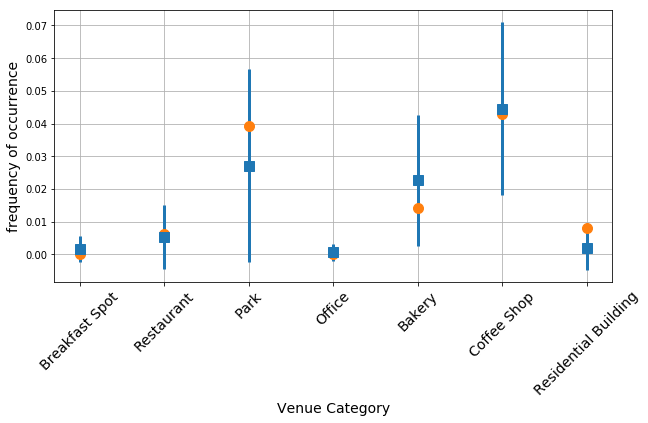

In [38]:
manhattan_bkfst = manhattan_merged[["Breakfast Spot","Restaurant","Park","Office","Bakery","Coffee Shop","Residential Building (Apartment / Condo)"]]
cluster4_mean = np.array(cluster_mean.iloc[2, 0:7])

xtick_label = ["Breakfast Spot","Restaurant","Park","Office","Bakery","Coffee Shop","Residential Building"]
x = np.array([1,2,3,4,5,6,7])
freq_mean = np.array(manhattan_bkfst.mean())
freq_std = np.array(manhattan_bkfst.std())

fig = plt.figure(figsize=(10, 5))
plt.errorbar(x, freq_mean, freq_std, linestyle='None', marker='s', linewidth=3, markersize=10)
plt.xlabel('Venue Category', fontsize=14)
plt.ylabel('frequency of occurrence', fontsize=14)
plt.xticks([1,2,3,4,5,6,7], xtick_label, fontsize=14, rotation = 45)

plt.plot(x, cluster4_mean, linestyle='None', marker='o', markersize=10)

plt.grid()
plt.show()

### Examine each cluster separately

In [39]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0]

,Cluster Labels,Neighborhood,Breakfast Spot,Restaurant,Park,Office,Bakery,Coffee Shop,Residential Building (Apartment / Condo),Borough,Latitude,Longitude
0,0,Battery Park City,0.0,0.0,0.112676,0.0,0.0,0.070423,0.0,Manhattan,40.711932,-74.016869
25,0,Morningside Heights,0.0,0.0,0.095238,0.0,0.0,0.071429,0.0,Manhattan,40.808000,-73.963896


In [40]:
cluster2_tbl = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2]
cluster2_tbl

,Cluster Labels,Neighborhood,Breakfast Spot,Restaurant,Park,Office,Bakery,Coffee Shop,Residential Building (Apartment / Condo),Borough,Latitude,Longitude
5,2,Civic Center,0.0,0.000000,0.043011,0.0,0.021505,0.053763,0.000000,Manhattan,40.715229,-74.005415
10,2,Flatiron,0.0,0.010000,0.030000,0.0,0.010000,0.020000,0.000000,Manhattan,40.739673,-73.990947
11,2,Gramercy,0.0,0.011905,0.023810,0.0,0.011905,0.047619,0.000000,Manhattan,40.737210,-73.981376
14,2,Hudson Yards,0.0,0.017857,0.035714,0.0,0.000000,0.035714,0.017857,Manhattan,40.756658,-74.000111
28,2,Roosevelt Island,0.0,0.000000,0.035714,0.0,0.000000,0.035714,0.035714,Manhattan,40.762160,-73.949168
31,2,Sutton Place,0.0,0.000000,0.040816,0.0,0.020408,0.061224,0.000000,Manhattan,40.760280,-73.963556
32,2,Tribeca,0.0,0.000000,0.064935,0.0,0.038961,0.038961,0.000000,Manhattan,40.721522,-74.010683
34,2,Turtle Bay,0.0,0.010000,0.040000,0.0,0.010000,0.050000,0.010000,Manhattan,40.752042,-73.967708


In [ ]:
cluster2_tbl.to_csv('cluster2_tbl.csv')

In [41]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4]

,Cluster Labels,Neighborhood,Breakfast Spot,Restaurant,Park,Office,Bakery,Coffee Shop,Residential Building (Apartment / Condo),Borough,Latitude,Longitude
30,4,Stuyvesant Town,0.0,0.000000,0.117647,0.000000,0.0,0.000000,0.0,Manhattan,40.731000,-73.974052
33,4,Tudor City,0.0,0.013514,0.067568,0.013514,0.0,0.013514,0.0,Manhattan,40.746917,-73.971219
